In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns

In [2]:
# get the DF used for setting the weights and analysis
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(0.5 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df1 = df[df['radiant_win'].notnull()]

2017-05-21 11:08:48.150507
Using this many files 4978


In [3]:

df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df1.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [14]:
df

,barracks_status_dire,barracks_status_radiant,dire_pos1,dire_pos1_ancient_kills,dire_pos1_apm,dire_pos1_assists,dire_pos1_camps_stacked,dire_pos1_courier_kills,dire_pos1_deaths,dire_pos1_denies,...,radiant_pos5_rune_pickups,radiant_pos5_sentry_uses,radiant_pos5_totalgold,radiant_pos5_totalxp,radiant_pos5_tower_kills,radiant_pos5_xpm,radiant_win,tower_status_dire,tower_status_radiant,residual
59,0,63,48,NaN,NaN,15,NaN,NaN,8,6,...,NaN,NaN,13449.0,17066.0,NaN,420,True,0,1846,1.376544e+06
99,0,63,16,NaN,NaN,4,NaN,NaN,4,1,...,NaN,NaN,8982.0,8467.0,NaN,378,True,0,2047,1.205126e+06
111,63,0,11,NaN,NaN,12,NaN,NaN,5,16,...,NaN,NaN,9828.0,14004.0,NaN,379,False,2038,0,1.184458e+06
290,63,0,44,NaN,NaN,29,NaN,NaN,13,0,...,NaN,NaN,15174.0,23660.0,NaN,474,False,1956,0,1.138350e+06
149,0,63,35,NaN,NaN,12,NaN,NaN,12,6,...,NaN,NaN,33187.0,26900.0,NaN,522,True,0,1844,1.092343e+06
216,0,63,2,NaN,NaN,11,NaN,NaN,19,2,...,NaN,NaN,16907.0,21933.0,NaN,624,True,0,2046,1.079648e+06
159,63,0,1,9.0,117.0,20,0.0,0.0,5,0,...,3.0,0.0,14691.0,21055.0,0.0,536,False,1974,0,1.059209e+06
57,0,63,8,NaN,NaN,8,NaN,NaN,11,11,...,NaN,NaN,32460.0,26909.0,NaN,509,True,0,1828,1.034486e+06
160,0,63,1,NaN,NaN,2,NaN,NaN,7,13,...,NaN,NaN,12921.0,14621.0,NaN,533,True,0,2038,1.025229e+06
189,63,3,89,NaN,NaN,12,NaN,NaN,4,0,...,NaN,NaN,10662.0,14626.0,NaN,321,False,1958,6,1.024374e+06


In [6]:
df['match_id'].values.tolist()

[3123015936,
 3123769088,
 3123269376,
 3123865856,
 3123442944,
 3123250944,
 3123553792,
 3123415552,
 3123224064,
 3123800064,
 3123424768,
 3123858944,
 3123339264,
 3123532032,
 3123740928,
 3123813888,
 3123113984,
 3123119360,
 3123797760,
 3123177728,
 3123902208,
 3123963904,
 3123676416,
 3123898368,
 3123671808,
 3123767808,
 3123298304,
 3123096320,
 3123169024,
 3123873280,
 3123214592,
 3123122688,
 3123501056,
 3123724288,
 3123286784,
 3123026432,
 3123257344,
 3123077376,
 3123683840,
 3123451136,
 3123344128,
 3123863552,
 3123445760,
 3123365632,
 3123595520,
 3123563264,
 3123182848,
 3123164928,
 3123231744,
 3123306496,
 3123047424,
 3123222272,
 3123804672,
 3123284224,
 3123307520,
 3123117568,
 3123741440,
 3123130624,
 3123658752,
 3123778048,
 3122990848,
 3123769344,
 3123190784,
 3123961088,
 3123848192,
 3123315200,
 3123373056,
 3123590912,
 3123545600,
 3123324416,
 3123403264,
 3123639552,
 3123128576,
 3122988288,
 3123910400,
 3122980352,
 3123700736,

In [7]:
df['residual'].values.tolist()

[1376544.125,
 1205126.0,
 1184458.375,
 1138350.0,
 1092342.75,
 1079647.625,
 1059209.375,
 1034485.6875,
 1025229.4375,
 1024373.8125,
 1013012.1875,
 1006514.875,
 1006391.125,
 997433.25,
 995918.25,
 981536.125,
 966222.25,
 959943.4375,
 955190.0,
 951338.9375,
 948980.9375,
 940999.375,
 936314.5625,
 936293.375,
 918626.0,
 914562.5,
 910749.875,
 902558.3125,
 901035.1875,
 897897.625,
 892004.4375,
 891875.75,
 889127.3125,
 887501.375,
 884834.0,
 877489.125,
 877308.0625,
 874454.3125,
 872661.625,
 872526.8125,
 870531.0,
 869197.0625,
 868918.0625,
 866448.25,
 865680.25,
 861261.5,
 856766.8125,
 855424.75,
 853797.0,
 853681.125,
 852267.375,
 851012.375,
 843084.4375,
 841888.8125,
 829920.4375,
 829055.0625,
 827215.6875,
 825245.375,
 819861.5,
 817646.6875,
 817224.75,
 808859.4375,
 807708.4375,
 806073.5,
 797702.3125,
 796814.1875,
 795913.75,
 795126.5,
 790762.1875,
 790512.25,
 789613.25,
 787611.5625,
 785633.9375,
 785416.8125,
 784566.0625,
 784488.5,
 783

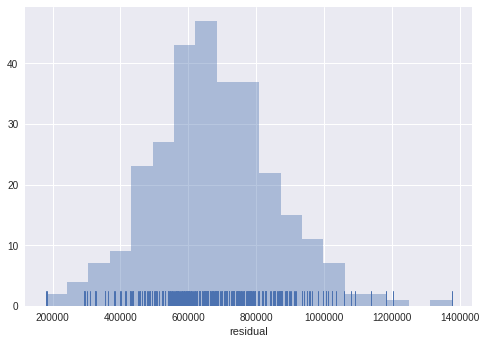

In [16]:
sns.distplot(df['residual'],  kde=False, rug=True)
plt.show()

In [9]:
len(df)

297

In [10]:
plt.close()

In [11]:
residuals = df['residual'].values.tolist()

In [12]:
np.max(residuals) - np.min(residuals)

1197002.75

In [13]:
df['residual']

59     1.376544e+06
99     1.205126e+06
111    1.184458e+06
290    1.138350e+06
149    1.092343e+06
216    1.079648e+06
159    1.059209e+06
57     1.034486e+06
160    1.025229e+06
189    1.024374e+06
89     1.013012e+06
52     1.006515e+06
258    1.006391e+06
200    9.974332e+05
237    9.959182e+05
117    9.815361e+05
132    9.662222e+05
110    9.599434e+05
248    9.551900e+05
156    9.513389e+05
172    9.489809e+05
122    9.409994e+05
202    9.363146e+05
19     9.362934e+05
139    9.186260e+05
123    9.145625e+05
294    9.107499e+05
6      9.025583e+05
208    9.010352e+05
106    8.978976e+05
           ...     
167    4.575566e+05
58     4.559194e+05
234    4.509386e+05
91     4.374827e+05
85     4.370409e+05
186    4.363522e+05
127    4.355871e+05
176    4.333469e+05
219    4.315151e+05
97     4.292451e+05
231    4.282213e+05
83     4.160536e+05
46     4.140833e+05
256    4.017697e+05
136    3.994880e+05
194    3.836924e+05
120    3.809299e+05
143    3.637163e+05
48     3.541172e+05
